## 1. Module Import and Hyper-parameters Setting

### 1-1. Setup & Module Import

In [ ]:
!pip install -U pip qiskit[visualization]

In [ ]:
#!pip install qiskit-aer-gpu

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# import os
import time
import numpy as np
from numpy.random import default_rng

import qiskit
import pylatexenc
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.extensions import Initialize
from qiskit.algorithms import optimizers

### 1-2. Setting of the main hyper-parameters of the model

In [ ]:
BATCH_SIZE = 100
n_qubits = 3
n_params = 12
n_shots = 1024
iteration = 100
n_epochs = 30
n_layers = 1    # Number of random layers

SAVE_PATH = "aeqis/" # Data saving folder
seed = 2022
np.random.seed(seed)        # Seed for NumPy random number generator
rng = default_rng(seed)
qiskit.utils.algorithm_globals.random_seed = seed

isReal = False # 'True' for real device or 'False' for simulator
use_gpu = False

## 2. Construct Quantum Circuit

### 2-1. One Qubit Unitary Circuit 

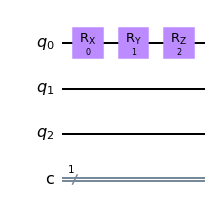

In [ ]:
def one_qubit_unitary(params, wire):  # need 3 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '1 Qubit Unitary')

  circ.rx(params[0],wire)
  circ.ry(params[1],wire)
  circ.rz(params[2],wire)
  
  return circ

params = np.arange(0, 3)
one_qubit_unitary(params, 0).draw(output='mpl')

### 2-2. Two Qubits Unitary Circuit

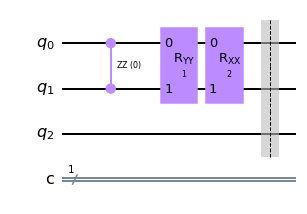

In [ ]:
def two_qubit_unitary(params, wires):  # need 3 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '2 Qubit Unitary')
  '''
  circ.compose(one_qubit_unitary(params[0:3], wires[0]), inplace=True)
  circ.compose(one_qubit_unitary(params[3:6], wires[1]), inplace=True)
  circ.rzz(params[6], wires[0], wires[1])
  circ.ryy(params[7], wires[0], wires[1])
  circ.rxx(params[8], wires[0], wires[1])
  '''
  circ.rzz(params[0], wires[0], wires[1])
  circ.ryy(params[1], wires[0], wires[1])
  circ.rxx(params[2], wires[0], wires[1])
  #circ.compose(one_qubit_unitary(params[9:12], wires[0]), inplace=True)
  #circ.compose(one_qubit_unitary(params[12:15], wires[1]), inplace=True)
  circ.barrier()

  return circ

params = np.arange(0, 15)
two_qubit_unitary(params, [0,1]).draw(output='mpl')

### 2-3. Decoder Circuit

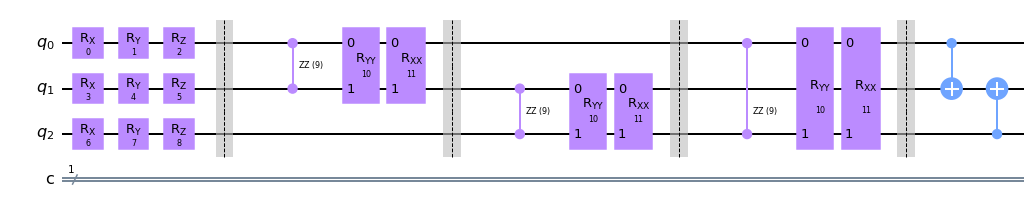

In [ ]:
def decoder(params, wires):  # need 12 parameters
  dec = QuantumCircuit(n_qubits, 1, name = '3 Qubit Unitary')
  dec.compose(one_qubit_unitary(params[0:3], [wires[0]]), inplace=True)
  dec.compose(one_qubit_unitary(params[3:6], [wires[1]]), inplace=True)
  dec.compose(one_qubit_unitary(params[6:9], [wires[2]]), inplace=True)

  dec.barrier()

  dec.compose(two_qubit_unitary(params[9:12], [wires[0],wires[1]]), inplace=True)
  dec.compose(two_qubit_unitary(params[9:12], [wires[1],wires[2]]), inplace=True)
  dec.compose(two_qubit_unitary(params[9:12], [wires[0],wires[2]]), inplace=True)

  dec.cx(wires[0], wires[1])
  dec.cx(wires[2], wires[1])
  #dec.barrier()

  #dec.measure(n_qubits//2, 0)   
  #circ.barrier()

  return dec

params = np.arange(0, 12)
decoder(params, [0,1,2]).draw(output='mpl')

### 2-4. Encoder Circuit

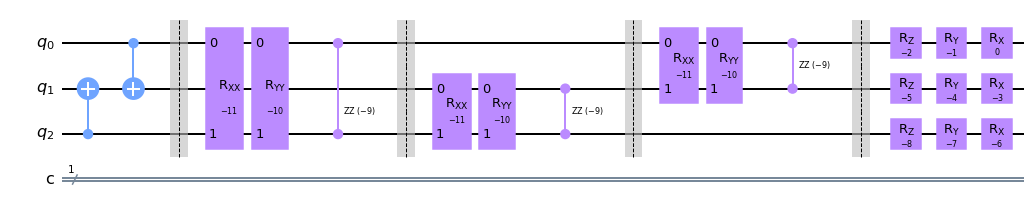

In [ ]:
# Defining Encoder circuit. Encoder is inversion of Decoder.
def encoder(decoder):
    enc = QuantumCircuit(n_qubits, 1, name = 'Encoder')
    enc = decoder.inverse()
    
    return enc

# visualizing Encoder to check
params = np.arange(0, 12)
encoder(decoder(params, np.arange(0,3))).draw(output='mpl')

### 2-5. Noise Model

In [ ]:
circ = QuantumCircuit(3,1)
x_p = 0.2
z_p= 0.3
xz_p = 0.5

def random_circuit(n,x_p,z_p,xz_p):
    circ = QuantumCircuit(n_qubits,1)
    p = x_p + z_p + xz_p
    #print(f"bit flip 확률:{x_p}\nphase flip 확률:{z_p}\nbit and phase flip 확률 :{xz_p},\nIdentitiy(non error):{1-p}")
    
    a = rng.choice(np.arange(1, 5), p=[x_p, z_p, xz_p,1-p ])
    if a ==[1]:
        circ.x(n)
    elif a ==[2]:
        circ.z(n)
    elif a ==[3]:
        circ.x(n)
        circ.z(n)
    elif a ==[4]:
        pass
    return circ
random_circuit(1,x_p,z_p,xz_p).draw()

q_0: ─────
     ┌───┐
q_1: ┤ Z ├
     └───┘
q_2: ─────
          
c: 1/═════

### 2-6. Complete Circuit

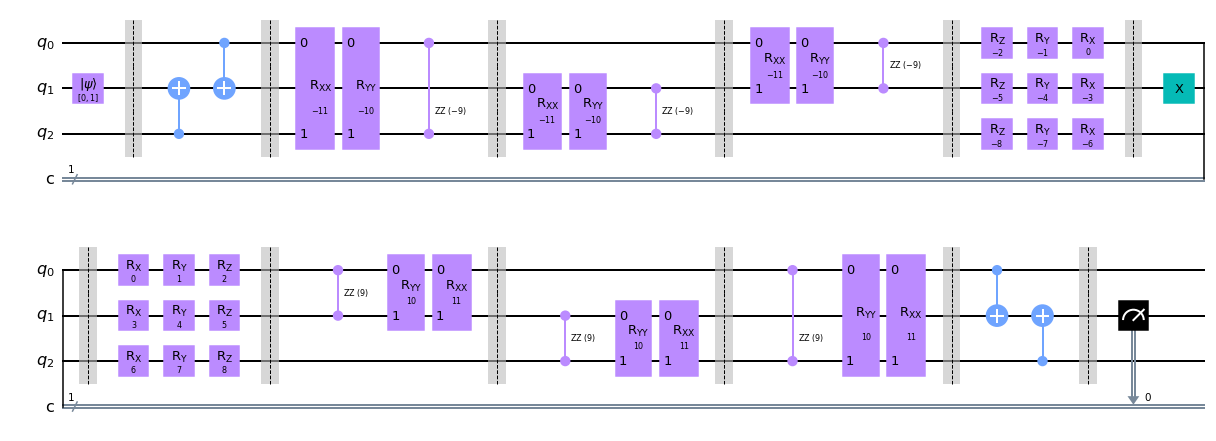

In [ ]:
def qae(params, wires, input_state, error_qubit):  # need 90 parameters
  qc = QuantumCircuit(n_qubits, 1, name = 'Quantum Autoencoder')
  qc.append(input_state, [n_qubits//2])
  qc.barrier()

  dec = decoder(params, np.arange(0,n_qubits))
  qc.compose(encoder(dec), inplace=True)

  # Add noise
  # qc.barrier()
  # qc += noisemodel(error_qubit)
  
  qc.barrier()
  qc.compose(random_circuit(1,x_p,z_p,xz_p),inplace=True)
  qc.barrier()
  
  qc.compose(dec, inplace=True)

  qc.barrier()
  #qc.measure(np.arange(0,9), np.arange(0,9))
  qc.measure(n_qubits//2,0)

  return qc

params = np.arange(0, 15)
wires = np.arange(0,n_qubits)
initial_state = [0, 1]
input_state = Initialize(initial_state)
qae(params, wires, input_state, 1).draw(output='mpl')

## 3. Optimization

### 3-1. Generalize Output

In [ ]:
def gen_states(output_state, target_state):
  '''
  alpha = 0
  for i in range(16):
    alpha += np.sum(np.power([abs(output_state[32*i+j]) for j in range(16)],2))
  alpha = np.sqrt(alpha)
    
  if alpha == 0:
    for i in range(16):
      beta += np.power([abs(output_state[32*i+16+j]) for j in range(16)], 2)
    beta = np.sqrt(beta)

  else:
    pseudo_alpha = 0
    for i in range(16):
      beta += np.sum([output_state[32*i+16+j] for j in range(16)])
      pseudo_alpha += np.sum([output_state[32*i+j] for j in range(16)])
    beta = beta / pseudo_alpha * alpha
    '''
  alpha = output_state['0'] / (output_state['0'] + output_state['1'])
  beta = output_state['1'] / (output_state['0'] + output_state['1'])
    
  a, b = target_state[0], target_state[1]
  a = np.power(a,2) / (np.power(a,2) + np.power(b,2))
  b = np.power(b,2) / (np.power(a,2) + np.power(b,2))
    
  return np.array([alpha, beta]), np.array([a, b])

### 3-2. Configuring Qiskit Backend

In [ ]:
if isReal:
  #from qiskit.providers.ibmq
  backend = qml.device("qiskit.ibmq", wires=n_qubits)
else:
  from qiskit.providers.aer import AerSimulator
  #backend = AerSimulator(method='statevector')
  from qiskit import Aer
  backend = AerSimulator(method="statevector")
  if use_gpu:
    #backend.available_devices()
    backend.set_options(device='GPU')

In [ ]:
qc = qae(params, np.arange(0,n_qubits), input_state, 1)

      # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
result = execute(qc, backend).result()
output_state = result.get_counts()
print(output_state)

{'1': 9, '0': 1015}


### 3-3. Create Cost Function

In [ ]:
def cost(params, input_batch):
  cost = 0
    
  for input_state in input_batch:
    target_state = input_state
    # initialize state
    input_state = Initialize(input_state)

    '''    
    for error_qubit in np.arange(-1, n_qubits):
      # Obtain a quantum circuit instance from the paramters
      qc = qae(params, np.arange(0,n_qubits), input_state, error_qubit)

      # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
      result = execute(qc, backend).result()
      output_state = result.get_counts()
      
      if not '0' in output_state:
        output_state['0'] = 0
      elif not '1' in output_state:
        output_state['1'] = 0
      np.array(sorted(output_state.keys()))

      output_state, target_state = gen_states(output_state, target_state)
      # adding cost for single circuit
      cost += np.linalg.norm(output_state - target_state)
      '''
    # Obtain a quantum circuit instance from the paramters
    qc = qae(params, np.arange(0,n_qubits), input_state, 1)

    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend).result()
    output_state = result.get_counts()
    if not '0' in output_state:
      output_state['0'] = n_shots - output_state['1']
    elif not '1' in output_state:
      output_state['1'] = n_shots - output_state['0']
    output_state, target_state = gen_states(output_state, target_state)
    
    # adding cost for single circuit
    cost += np.linalg.norm(output_state - target_state)

  # returning total cost
  return cost

### 3-4. Define Batch Generator & Optimizer

In [ ]:
# Function to create batch according to batch size
def create_batch(batch_size):
  # Function to return an array after normalizing the elements
  def normalize(arr):
    return arr / np.linalg.norm(arr)
  # Generating random_states
  random_states = np.random.rand(batch_size * 2) + np.random.rand(batch_size * 2)*1j
  # Creating normalized input states from random states and appending to an array
  input_batch = np.array([normalize([random_states[i], random_states[i + 1]]) for i in range(0, 2 * batch_size, 2)])
  # Creating target states corresponding to the input states
  # target_states = [[input_states[i][0], 0, input_states[i][1], 0, 0, 0, 0, 0] for i in range (batch_size)]

  return input_batch

In [ ]:
def optimize_circuit(initial_params, iteration, num_epoch, batch_size):
  current_params = initial_params
  current_error = None
  data = []
    
  # Defining global variables
  #global input_batch
  #global target_states
  global results
    
  input_batch = create_batch(batch_size)

  # Initialize the optimizer
  optimizer = optimizers.COBYLA(maxiter = iteration, args=(input_batch,))
    
  # Running batch optimization epoch by epoch
  for i in range (0, num_epoch):
    iter_start = time.time()
    # run optimizer
    ret = optimizer.optimize(num_vars=len(initial_params), 
                             objective_function=cost, 
                             initial_point=current_params)
        
    current_params = ret[0]
    current_error = ret[1]
        
    print("Finished Epoch: " + str(i+1) + " ..... " + "Iteration: " + str(iteration) + " ..... " + "Current Error: " + str(current_error) + " ..... " + " Time running: " + str(time.time() - iter_start) + " seconds")
        
    # Simulation result for all circuits will be stored in this list
    data.append(current_error)
    print(current_params)
    
  # A list to contain each number of epoch
  epoch_list = np.arange(1, (num_epoch + 1))
  # Adding errror and corresponding circuit number to a list
  results = [data, epoch_list]
    
  # returning final optimized parameters and error
  return current_params, current_error

### 3-5. Initialize Parameters

In [ ]:
initial_params = np.random.uniform(0, 2*np.pi, 12)
# initial_params = np.array([math.pi, 0, math.pi, math.pi, 0, math.pi])
print("Initial Parameters:")
print(initial_params)

Initial Parameters:
[0.0588019  3.1356727  0.71241073 0.31399602 4.30654293 3.05983627
 5.6401467  4.06806134 5.63578551 4.53102439 5.2235476  5.19976353]


### 3-6. Run Optimizer

In [ ]:
results = []

# Optimizing and printing the results
iter_start = time.time()
optimized_params, error = optimize_circuit(initial_params, iteration, n_epochs, BATCH_SIZE)

print(iteration,"Iterations..... 12 parameters optimized.....", (time.time() - iter_start), "seconds for running")
print()
print("Error:")
print(error)
print()
print("Optimized Parameters:")
print(optimized_params)

Finished Epoch: 1 ..... Iteration: 100 ..... Current Error: 92.77292247579048 .....  Time running: 357.047061920166 seconds
[0.06142017 3.13343714 0.71584839 0.31091405 4.30522509 3.05895522
 5.64058628 4.11121224 5.5149321  4.53142564 5.22478712 5.19980804]
Finished Epoch: 2 ..... Iteration: 100 ..... Current Error: 88.41158394631644 .....  Time running: 358.38680768013 seconds
[-0.22277854  2.85663647  0.49063687  0.1167823   4.21803105  2.65384909
  5.39726237  3.84308148  5.36268739  4.40441653  4.66327265  4.88992821]
Finished Epoch: 3 ..... Iteration: 100 ..... Current Error: 80.02342027830888 .....  Time running: 353.29089641571045 seconds
[0.41467064 2.68387423 0.62467739 1.39218285 3.35519383 2.80433045
 5.53127697 4.86022462 4.65147072 5.65589652 3.55155117 4.74373175]
Finished Epoch: 4 ..... Iteration: 100 ..... Current Error: 89.95156838760684 .....  Time running: 352.11209511756897 seconds
[1.41447266 2.68383793 1.62484238 1.39183116 3.35430016 2.80329675
 5.53133147 4.870

## 4. Plot Results for Comparison

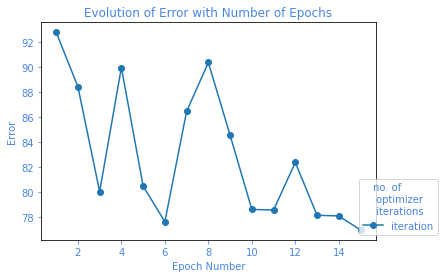

In [7]:
COLOR = '#4a87e0'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

results = [[92.77292247579048,88.41158394631644,80.02342027830888,
            89.95156838760684,80.46529073213401,77.61515456295444,
            86.4419373115683,90.35360550671001,84.53831603056277,
            78.59917503045732,78.55625330194788,82.35897325663635,
            78.13229352931569,78.0763207471465,76.96108573051387],
           np.arange(1,16)]
# function to plot results for comparison 
def plot_result(results):

    plt.plot(results[1], results[0], label='iteration', marker='o', ls='-')

    plt.xlabel('Epoch Number')
    plt.ylabel('Error')

    plt.title('Evolution of Error with Number of Epochs')

    plt.legend(loc="lower right", bbox_to_anchor=(1.2, 0), title='no. of \n optimizer\n iterations')
    plt.show()

plot_result(results)